In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/80-cereals/cereal.csv
/kaggle/input/cereal-2-csv/cereal (1).csv


# # Introduction

Cereal is a staple breakfast choice for millions worldwide, offering convenience and a variety of flavors. However, not all cereals are created equal when it comes to nutrition. The dataset in question provides detailed information about 80 different cereals, including their calorie content, sugar levels, protein, fiber, and ratings, among other attributes. This analysis aims to explore the nutritional profile of these cereals, understand how different factors such as sugar and fiber influence ratings, and identify patterns that can guide consumers in making healthier choices. Through preprocessing, visualization, and statistical analysis, we dive deep into the world of cereals to uncover actionable insights.





# 1. Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.preprocessing import StandardScaler,MultiLabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LinearRegression,Ridge,Lasso


# 2. Load the Dataset

Use the file path to load the dataset into a DataFrame.

In [3]:
# Load the dataset
file_path = '/kaggle/input/80-cereals/cereal.csv'
cereal_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print(cereal_data.head())


                        name mfr type  calories  protein  fat  sodium  fiber  \
0                  100% Bran   N    C        70        4    1     130   10.0   
1          100% Natural Bran   Q    C       120        3    5      15    2.0   
2                   All-Bran   K    C        70        4    1     260    9.0   
3  All-Bran with Extra Fiber   K    C        50        4    0     140   14.0   
4             Almond Delight   R    C       110        2    2     200    1.0   

   carbo  sugars  potass  vitamins  shelf  weight  cups     rating  
0    5.0       6     280        25      3     1.0  0.33  68.402973  
1    8.0       8     135         0      3     1.0  1.00  33.983679  
2    7.0       5     320        25      3     1.0  0.33  59.425505  
3    8.0       0     330        25      3     1.0  0.50  93.704912  
4   14.0       8      -1        25      3     1.0  0.75  34.384843  



# 3. Check the Dataset’s Structure   


This step helps understand the dataset's dimensions, data types, and any missing values.

In [4]:
# Dataset dimensions
print("Shape of the dataset:", cereal_data.shape)

# Data types of columns
print("Data types:\n", cereal_data.dtypes)

# Summary statistics
print("Summary statistics:\n", cereal_data.describe())

# Check for missing values
print("Missing values:\n", cereal_data.isnull().sum())


Shape of the dataset: (77, 16)
Data types:
 name         object
mfr          object
type         object
calories      int64
protein       int64
fat           int64
sodium        int64
fiber       float64
carbo       float64
sugars        int64
potass        int64
vitamins      int64
shelf         int64
weight      float64
cups        float64
rating      float64
dtype: object
Summary statistics:
          calories    protein        fat      sodium      fiber      carbo  \
count   77.000000  77.000000  77.000000   77.000000  77.000000  77.000000   
mean   106.883117   2.545455   1.012987  159.675325   2.151948  14.597403   
std     19.484119   1.094790   1.006473   83.832295   2.383364   4.278956   
min     50.000000   1.000000   0.000000    0.000000   0.000000  -1.000000   
25%    100.000000   2.000000   0.000000  130.000000   1.000000  12.000000   
50%    110.000000   3.000000   1.000000  180.000000   2.000000  14.000000   
75%    110.000000   3.000000   2.000000  210.000000   3.000000

# 4. Remove Duplicates
Duplicate rows (if any) can be removed to avoid redundant analysis.

In [5]:
# Remove duplicates
cereal_data = cereal_data.drop_duplicates()

print("Shape after removing duplicates:", cereal_data.shape)


Shape after removing duplicates: (77, 16)


# 5. Handle Negative Values

Negative values in numeric columns are replaced with NaN.

In [6]:
# Columns to check for negative values
numeric_columns = [
    "calories", "protein", "fat", "sodium", 
    "fiber", "carbo", "sugars", "potass", "vitamins", "weight", "cups"
]

# Replace negative values with NaN
for col in numeric_columns:
    cereal_data[col] = cereal_data[col].apply(lambda x: x if x >= 0 else np.nan)



# 6. Impute Missing Values  

Missing values are filled with the median of the respective columns.

In [7]:
# Fill missing values with median
for col in numeric_columns:
    cereal_data[col] = cereal_data[col].fillna(cereal_data[col].median())


# 7. Encode Categorical Variables

Convert categorical columns like mfr and type into numerical codes for further analysis.

In [8]:
# Encode categorical variables
cereal_data["mfr_encoded"] = cereal_data["mfr"].astype("category").cat.codes
cereal_data["type_encoded"] = cereal_data["type"].astype("category").cat.codes


# 8. Visualize Data

   
Generate key visualizations to better understand the data.

a. Distribution of Calories



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


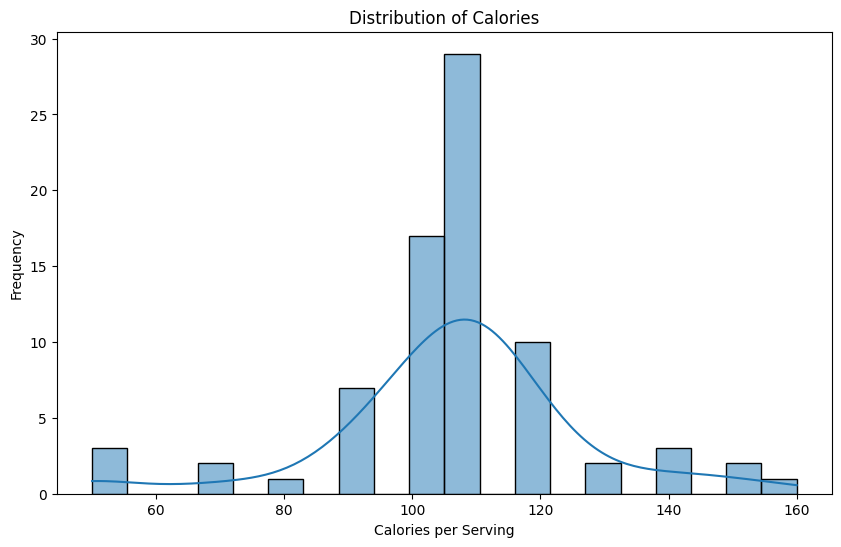

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(cereal_data["calories"], kde=True, bins=20)
plt.title("Distribution of Calories")
plt.xlabel("Calories per Serving")
plt.ylabel("Frequency")
plt.show()


b. Correlation Heatmap



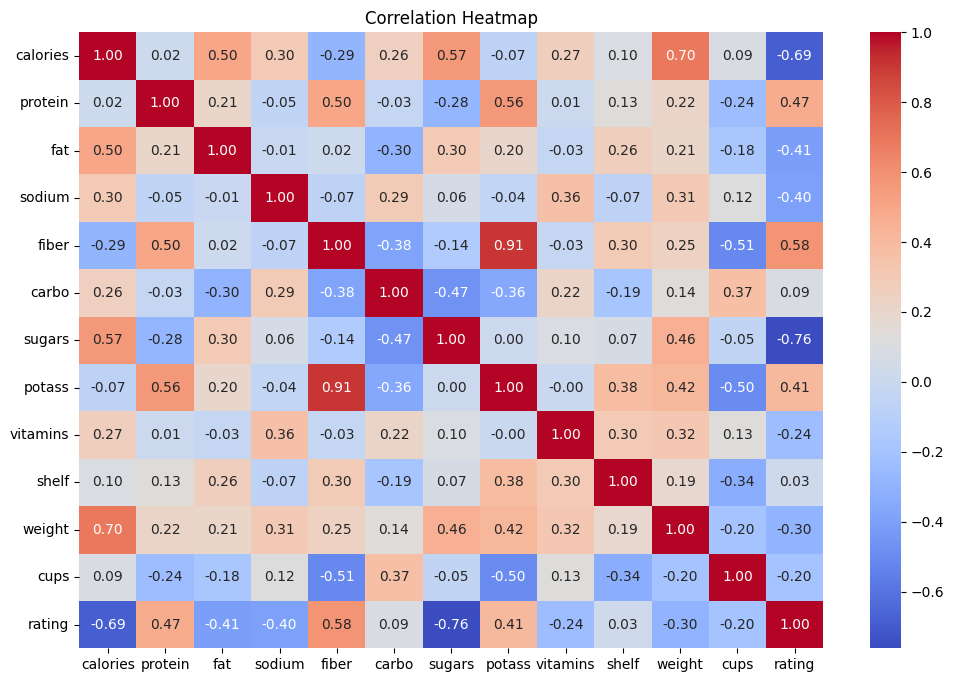

In [10]:
# Select only numeric columns for correlation calculation
numeric_data = cereal_data.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# c. Sugar Content vs Rating

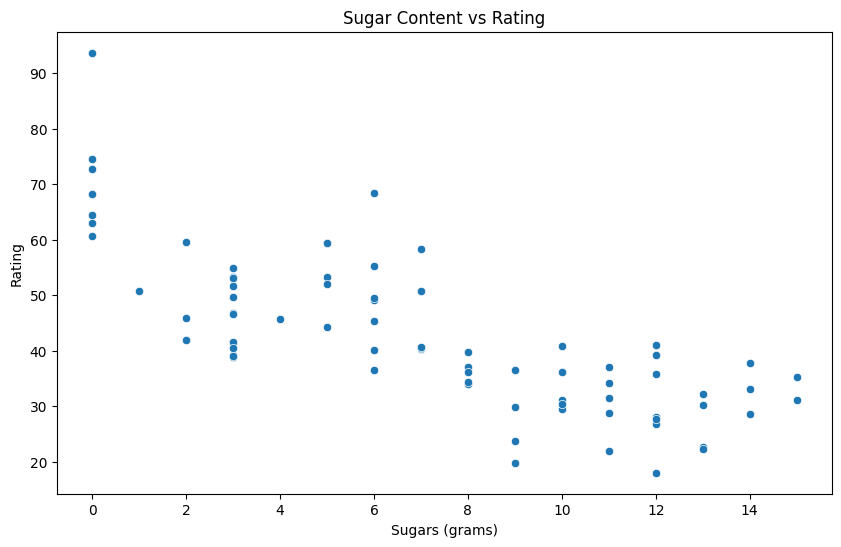

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cereal_data["sugars"], y=cereal_data["rating"])
plt.title("Sugar Content vs Rating")
plt.xlabel("Sugars (grams)")
plt.ylabel("Rating")
plt.show()


# D. Distribution of Ratings
Ratings are a key metric for cereals. Analyze their distribution to see how cereals are rated overall.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


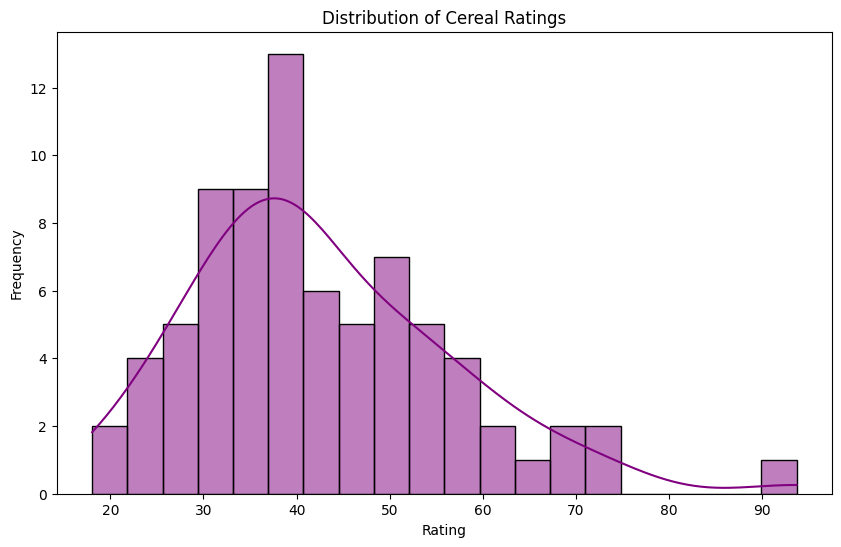

In [12]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(cereal_data["rating"], kde=True, bins=20, color="purple")
plt.title("Distribution of Cereal Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


# E.Relationship Between Fiber and Sugar Content

Analyze whether cereals with higher fiber tend to have lower sugar content, which might suggest they are healthier options.

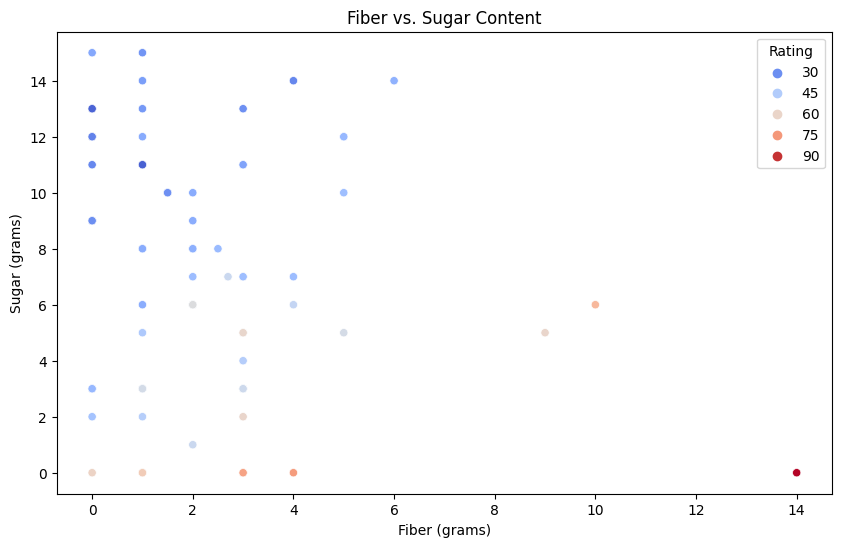

In [13]:
# Scatterplot: Fiber vs. Sugar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cereal_data["fiber"], y=cereal_data["sugars"], hue=cereal_data["rating"], palette="coolwarm")
plt.title("Fiber vs. Sugar Content")
plt.xlabel("Fiber (grams)")
plt.ylabel("Sugar (grams)")
plt.legend(title="Rating")
plt.show()


# F. Manufacturer Analysis

Explore the distribution of cereals by manufacturers to identify which company dominates the market.

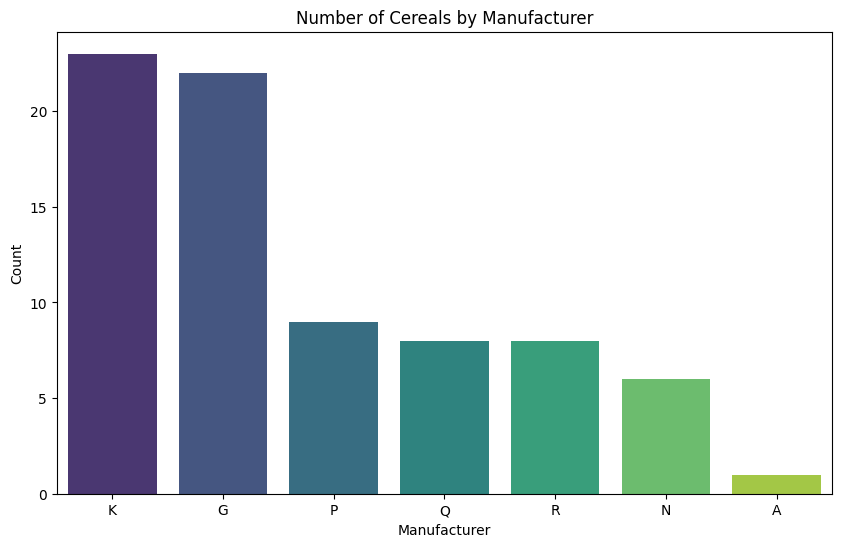

In [14]:
# Count plot for manufacturers
plt.figure(figsize=(10, 6))
sns.countplot(x="mfr", data=cereal_data, order=cereal_data["mfr"].value_counts().index, palette="viridis")
plt.title("Number of Cereals by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Count")
plt.show()


# G. Calories vs. Ratings
Examine whether there’s a relationship between the number of calories and the cereal ratings.

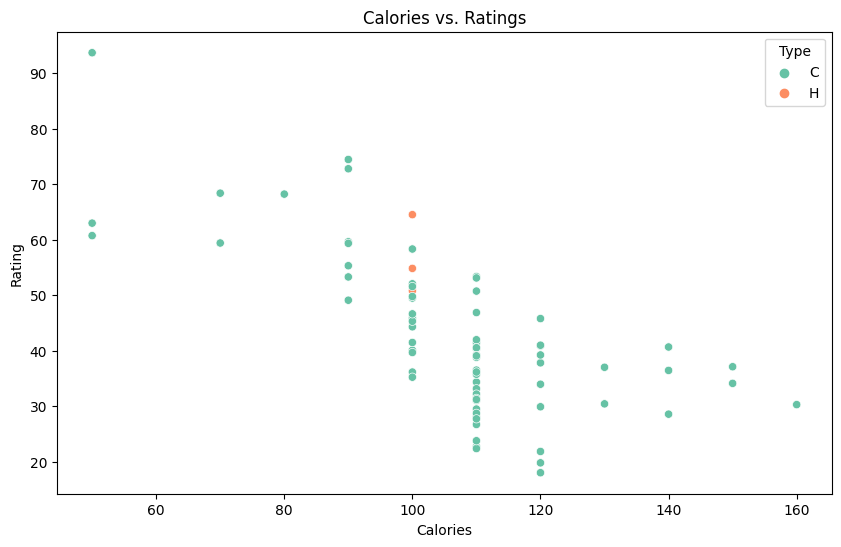

In [15]:
# Scatterplot: Calories vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cereal_data["calories"], y=cereal_data["rating"], hue=cereal_data["type"], palette="Set2")
plt.title("Calories vs. Ratings")
plt.xlabel("Calories")
plt.ylabel("Rating")
plt.legend(title="Type")
plt.show()


# H. Top 5 and Bottom 5 Cereals by Rating

Identify the best and worst-rated cereals to analyze what makes them stand out.

In [16]:
# Top 5 cereals
top_5 = cereal_data.nlargest(5, "rating")[["name", "rating"]]
print("Top 5 Cereals:\n", top_5)

# Bottom 5 cereals
bottom_5 = cereal_data.nsmallest(5, "rating")[["name", "rating"]]
print("\nBottom 5 Cereals:\n", bottom_5)


Top 5 Cereals:
                          name     rating
3   All-Bran with Extra Fiber  93.704912
64     Shredded Wheat 'n'Bran  74.472949
65  Shredded Wheat spoon size  72.801787
0                   100% Bran  68.402973
63             Shredded Wheat  68.235885

Bottom 5 Cereals:
                      name     rating
10           Cap'n'Crunch  18.042851
12  Cinnamon Toast Crunch  19.823573
35       Honey Graham Ohs  21.871292
18          Count Chocula  22.396513
14            Cocoa Puffs  22.736446


# I. Clustering of Cereals

If you’re looking to dive deeper, you can use clustering techniques (like K-Means) to group cereals based on their nutritional values.




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


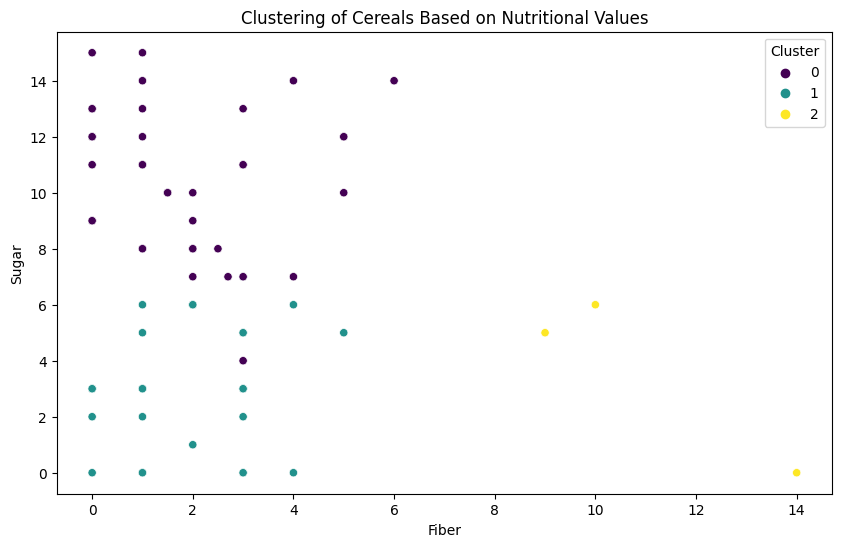

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features and standardize them
features = ["calories", "protein", "fat", "sodium", "fiber", "carbo", "sugars", "potass"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cereal_data[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cereal_data["cluster"] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cereal_data["fiber"], y=cereal_data["sugars"], hue=cereal_data["cluster"], palette="viridis")
plt.title("Clustering of Cereals Based on Nutritional Values")
plt.xlabel("Fiber")
plt.ylabel("Sugar")
plt.legend(title="Cluster")
plt.show()


# 9.conclusion

The analysis of the 80 cereals dataset revealed several key insights. High sugar content tends to negatively impact ratings, while cereals with more fiber and protein often receive better ratings, likely due to their perceived health benefits. Manufacturers like Kellogg's and General Mills dominate the market with a wide variety of cereals. Clustering analysis further demonstrated distinct groups of cereals based on their nutritional profiles, highlighting clear differences between sugary cereals and those targeted at health-conscious consumers. This study emphasizes the importance of carefully reviewing nutritional labels, especially for parents selecting cereals for children, as many popular options are high in sugar. Ultimately, a well-informed choice can make breakfast not only delicious but also nutritious.
